# Dimension Reduction


The notebook is to facilitate discussion on dimension reduction.

Literature:

Sargent & Sims (1977) "Business cycle modeling without pretending to have too much a priori economic theory" show that a small number of latent factors explains a large proportion of the variance in U.S. macroeconomic indicators.

Bai (2008) and Stock and Watson (2006) provide surveys of this literature.



---



## Principal Components

In [1]:
# Import necessary libraries
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

#### Retrieve Data

FRED-MD: A Monthly Database for Macroeconomic Research
See McCracken & Ng (2016).

In [2]:
# Retrieve the data
def load_data(fred_path: str):
    """
    Function to load data either from a local file or from FRED if the file doesn't exist locally.

    Args:
    fred_path (str): URL to fetch the dataset from FRED.

    Returns:
    DataFrame: Loaded dataset.
    """

    print("Be patient: loading from FRED (2 minutes)")
    df = pd.read_csv(fred_path)[:-3]
    print("Done")

    tcodes = df.iloc[0, 1:]  # data tickers
    df.drop(0, inplace=True) # Drop unnecessary row

    # Set index to date and format it as datetime
    df = df.set_index("sasdate", drop=True)
    df.index = pd.to_datetime(df.index, format='%m/%d/%Y')

    return df, tcodes


# Define paths for the dataset
fred_path = "https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv"

# Load the data
df, tcodes = load_data(fred_path)

Be patient: loading from FRED (2 minutes)
Done


In [3]:
df

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,2583.560,2426.0,15.188,2.766768e+05,18235.77392,21.9616,23.3868,22.2620,31.6664,18.9498,...,18.294,10.152,2.13,2.45,2.04,NaN,6476.00,12298.00,84.2043,NaN
1959-02-01,2593.596,2434.8,15.346,2.787140e+05,18369.56308,22.3917,23.7024,22.4549,31.8987,19.0492,...,18.302,10.167,2.14,2.46,2.05,NaN,6476.00,12298.00,83.5280,NaN
1959-03-01,2610.396,2452.7,15.491,2.777753e+05,18523.05762,22.7142,23.8459,22.5651,31.8987,19.4223,...,18.289,10.185,2.15,2.45,2.07,NaN,6508.00,12349.00,81.6405,NaN
1959-04-01,2627.446,2470.0,15.435,2.833627e+05,18534.46600,23.1981,24.1903,22.8957,32.4019,19.5466,...,18.300,10.221,2.16,2.47,2.08,NaN,6620.00,12484.00,81.8099,NaN
1959-05-01,2642.720,2486.4,15.622,2.853072e+05,18679.66354,23.5476,24.3911,23.1161,32.5567,19.9445,...,18.280,10.238,2.17,2.48,2.08,95.3,6753.00,12646.00,80.7315,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-01,19862.969,16232.7,119.248,1.508218e+06,700519.00000,102.7267,100.9719,100.9228,101.9449,107.5568,...,119.363,126.225,30.67,35.23,27.35,76.9,529015.93,921985.58,5113.1318,13.8808
2024-03-01,19912.546,16269.5,119.702,1.506005e+06,703738.00000,102.5186,100.6469,100.5767,101.4155,108.1002,...,119.583,126.771,30.79,35.35,27.46,79.4,533250.65,922906.63,5209.3977,13.7658
2024-04-01,19933.933,16284.5,119.695,1.502289e+06,702681.00000,102.3568,100.5038,100.5804,101.6516,106.0545,...,120.130,127.128,30.83,35.41,27.55,77.2,537931.83,924804.89,5162.2962,16.4023


##### Transform the Data

In [4]:
def transxf(x, tcode):
    """
    DESCRIPTION:
    This function transforms a single series (in a column vector)
    as specified by a given transformation code.

    INPUT:
        x      : Series (in a column vector) to be transformed
        tcode  : Transformation code (1-7)

    OUTPUT:
        result : Transformed series (as a column vector)

    """
    # Number of observations (including missing values)
    n = x.size

    # Value close to zero
    small = 1e-6

    # Allocate output variables
    y = np.nan * np.ones(n)
    y1 = np.nan * np.ones(n)

    # Initialize result to ensure it's always defined
    result = np.nan * np.ones(n)

    # Transformation logic
    if tcode == 1:  # No transformation: x(t)
        result = x

    elif tcode == 2:  # First difference: x(t) - x(t-1)
        y[1:] = x[1:] - x[:-1]
        result = y

    elif tcode == 3:  # Second difference: (x(t) - x(t-1)) - (x(t-1) - x(t-2))
        y[2:] = x[2:] - 2 * x[1:-1] + x[:-2]
        result = y

    elif tcode == 4:  # Natural log: ln(x)
        if np.min(x) < small:
            result = np.nan
        else:
            result = np.log(x)

    elif tcode == 5:  # First difference of natural log: ln(x) - ln(x-1)
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[1:] = log_x[1:] - log_x[:-1]
            result = y

    elif tcode == 6:  # Second difference of natural log
        if np.min(x[pd.notnull(x)]) > small:
            log_x = np.log(x)
            y[2:] = log_x[2:] - 2 * log_x[1:-1] + log_x[:-2]
            result = y

    elif tcode == 7:  # First difference of percent change
        y1[1:] = (x[1:] - x[:-1]) / x[:-1]
        y[2:] = y1[2:] - y1[1:-1]
        result = y

    return result


yt = []             # Initialize output variable
N = df.shape[1]     # Number of series kept

for i in range(N):
    dum = transxf(df.iloc[:, i].values, tcodes[i])
    yt.append(dum)

transformed_data = pd.DataFrame(yt).T
transformed_data.columns = df.columns

<ipython-input-4-4286bc006f4d>:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dum = transxf(df.iloc[:, i].values, tcodes[i])


In [5]:
transformed_data

,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.003877,0.003621,0.010349,0.007336,0.007310,0.019395,0.013405,0.008628,0.007309,0.005232,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.006457,0.007325,0.009404,-0.003374,0.008321,0.014300,0.006036,0.004896,0.000000,0.019397,...,-0.001148,0.000292,-0.000022,-0.008147,0.004819,NaN,0.004929,0.004138,-0.014792,NaN
3,0.006510,0.007029,-0.003622,0.019915,0.000616,0.021080,0.014339,0.014545,0.015652,0.006379,...,0.001312,0.001760,-0.000022,0.012203,-0.004890,NaN,0.012134,0.006734,0.024929,NaN
4,0.005796,0.006618,0.012043,0.006839,0.007803,0.014954,0.008267,0.009580,0.004766,0.020152,...,-0.001695,-0.001867,-0.000021,-0.004090,-0.004819,NaN,0.002828,0.002020,-0.015342,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
781,0.001194,0.000302,0.002284,0.004417,0.007002,0.012181,0.010656,0.008538,0.006827,0.034180,...,0.010049,-0.004593,-0.001653,-0.011091,0.002188,-2.1,-0.000916,-0.001805,-0.003951,13.8808
782,0.002493,0.002264,0.003800,-0.001468,0.004585,-0.002028,-0.003224,-0.003435,-0.005207,0.005039,...,-0.004605,0.001976,0.000639,0.005385,-0.001118,2.5,0.001697,0.001887,0.018563,13.7658
783,0.001073,0.000922,-0.000058,-0.002471,-0.001503,-0.001579,-0.001423,0.000037,0.002325,-0.019105,...,0.002722,-0.001504,-0.002607,-0.001705,-0.000742,-2.2,0.000767,0.001056,-0.027735,16.4023
784,0.004582,0.005011,0.004867,0.006177,0.002314,0.006954,0.004263,0.002386,0.002594,-0.005753,...,-0.006055,-0.001256,0.001940,-0.000003,0.000351,-8.1,-0.000418,0.000643,0.011417,12.8609


#### Standardize the Data

In [6]:
"""
Many macroeconomic indicators in the FRED-MD dataset (e.g., interest rates, employment figures, and stock indices) have vastly different scales.
Without standardization, variables with larger numerical values may exert disproportionate influence on the PCA.
"""

# Drop NaNs generated by transformations
transformed_data.dropna(inplace=True)

# Standardize the transformed data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(transformed_data), columns=transformed_data.columns, index=transformed_data.index)


#### Estimating the Principal Components

In [7]:
pca = PCA(n_components=10, whiten=True, svd_solver='full', random_state=42)
pca.fit(df_scaled)

PCA(n_components=10, random_state=42, svd_solver='full', whiten=True)

#### Selecting the Number of Components

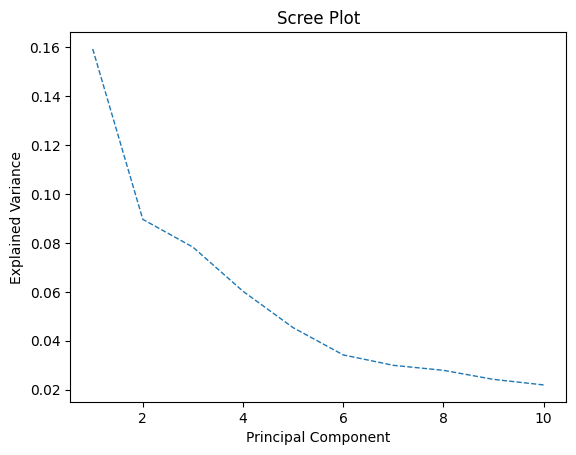

In [8]:
plt.figure()
plt.plot(np.arange(pca.n_components_) + 1, pca.explained_variance_ratio_, '--', linewidth=1)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')

plt.show()

In [9]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Decide on the number of components (e.g., explaining 75% variance)
n_components = np.argmax(cumulative_variance >= 0.5) + 1
print(f'Number of components explaining 50% of the variance: {n_components}')

Number of components explaining 50% of the variance: 8


#### Estimated Components

In [10]:
pca_indices = pd.DataFrame(pca.transform(df_scaled), index=df_scaled.index)
pca_indices

,0,1,2,3,4,5,6,7,8,9
398,0.523028,0.178162,-0.880636,1.061629,-1.584514,-0.780021,0.236700,-0.597653,0.086291,-0.511048
399,0.090177,0.446271,-0.896012,-0.472369,-0.412481,-0.190860,1.160506,-0.023771,0.915826,-0.895692
400,0.039335,0.526992,-0.587202,-0.407572,-0.566841,0.052870,1.022547,0.750940,-0.765566,0.051594
401,-0.270236,0.608779,-0.428672,0.044912,-0.553325,0.042958,1.059840,1.035171,-0.381941,0.246351
402,-0.113310,0.676415,-0.792660,-1.809708,-0.167345,-0.164622,2.245512,0.509793,0.814262,-1.038521
...,...,...,...,...,...,...,...,...,...,...
781,0.655370,0.445970,0.939518,-0.259135,-0.345854,-1.051830,-0.786111,-1.670868,-1.044252,2.134035
782,0.045476,-0.568605,0.349504,-0.673414,0.183747,1.123514,-1.599268,-0.295073,-1.026863,1.069590
783,-0.255282,-0.292456,0.714097,0.518182,0.059038,-0.377843,-1.842211,-1.161259,0.742846,0.835932
784,0.065520,-1.160677,-0.324880,-1.022566,0.198467,0.425692,-0.433668,-0.350339,-0.657835,2.126231


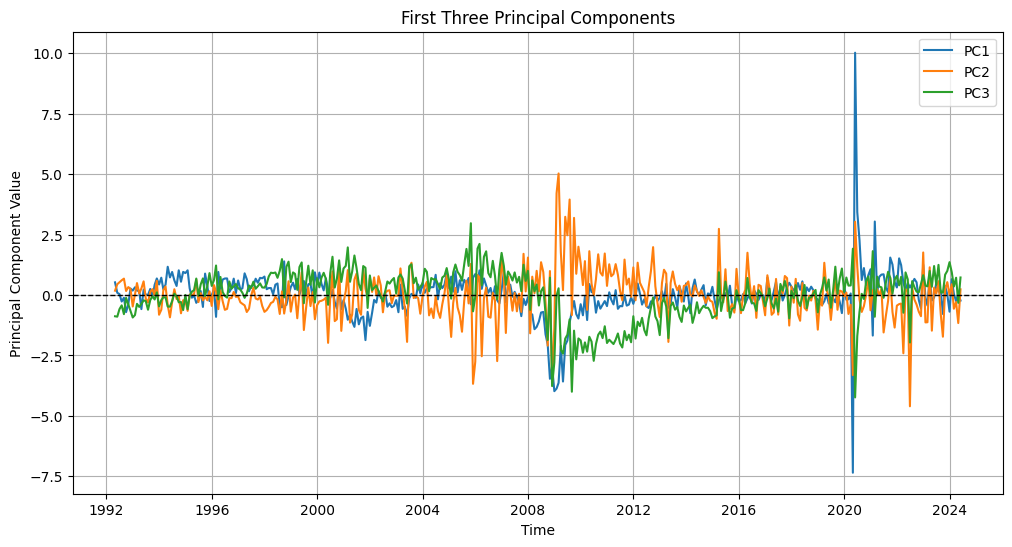

In [11]:
columns = []
for _ in np.arange(pca.n_components_) + 1:
    pc_name = "PC"+str(_)
    columns.append(pc_name)

pca_indices.columns = columns

# Plot the first three principal components
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(pca_indices):], pca_indices["PC1"], label="PC1")
plt.plot(df.index[-len(pca_indices):], pca_indices["PC2"], label="PC2")
plt.plot(df.index[-len(pca_indices):], pca_indices["PC3"], label="PC3")
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Add a reference line
plt.legend()
plt.title("First Three Principal Components")
plt.xlabel("Time")
plt.ylabel("Principal Component Value")
plt.grid(True)
plt.show()

#### Estimated Loadings -- Interpretation

In [12]:
pca_loadings = pd.DataFrame(pca.components_.T, index=df_scaled.columns.values)
pca_loadings

,0,1,2,3,4,5,6,7,8,9
RPI,0.041688,-0.030499,-0.030511,-0.027426,-0.024622,-0.036479,0.062359,-0.195678,-0.269322,-0.023391
W875RX1,0.074947,-0.060128,-0.033134,-0.035399,0.028799,0.047222,0.010344,-0.002921,-0.135075,-0.009063
DPCERA3M086SBEA,0.150657,0.045501,-0.043132,-0.068573,-0.089735,0.059770,-0.077615,-0.092155,-0.032061,-0.103516
CMRMTSPLx,0.145324,0.016967,-0.067126,-0.086926,-0.053153,0.034280,0.027020,-0.059520,-0.053256,-0.004583
RETAILx,0.137485,0.084787,-0.014182,-0.024079,-0.063549,0.037414,-0.037982,-0.144949,-0.093546,-0.097779
...,...,...,...,...,...,...,...,...,...,...
UMCSENTx,0.027061,0.019302,-0.024299,0.039513,-0.051433,0.168616,-0.099291,-0.051450,-0.020496,-0.090793
DTCOLNVHFNM,0.005492,0.015334,-0.004522,-0.008196,-0.049470,-0.028339,-0.078074,-0.098606,0.259078,0.048395
DTCTHFNM,0.005774,0.013172,-0.002025,0.005172,-0.034001,-0.064557,-0.080147,-0.089043,0.264203,0.056808
INVEST,0.002976,0.023000,0.008529,-0.014836,0.017350,-0.061355,0.010023,0.082162,-0.167332,0.117035


In [13]:
# Get PCA loadings (eigenvectors)
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose so that rows correspond to original features
    index=df_scaled.columns,  # Original feature names
    columns=columns  # Label components
)

# Find top contributing series for each principal component
top_n = 5  # Number of top series to display

for pc in loadings.columns:
    top_contributors = loadings[pc].abs().nlargest(top_n).index
    print(f"Top {top_n} contributing series to {pc}:")
    print(loadings.loc[top_contributors, pc])  # Sort by absolute value of loadings
    print("\n")

Top 5 contributing series to PC1:
PAYEMS       0.192797
IPMANSICS    0.189380
IPFPNSS      0.185245
SRVPRD       0.184106
INDPRO       0.181254
Name: PC1, dtype: float64


Top 5 contributing series to PC2:
CUSR0000SA0L5    0.243249
CPIAUCSL         0.243242
CPIULFSL         0.242797
CUSR0000SA0L2    0.242570
CPITRNSL         0.235852
Name: PC2, dtype: float64


Top 5 contributing series to PC3:
PERMIT     0.243820
PERMITW    0.240878
HOUSTW     0.239638
HOUST      0.238841
PERMITS    0.236484
Name: PC3, dtype: float64


Top 5 contributing series to PC4:
GS1         0.267123
TB6SMFFM    0.262986
TB6MS       0.260432
T1YFFM      0.255845
TB3MS       0.234418
Name: PC4, dtype: float64


Top 5 contributing series to PC5:
CES0600000007    0.277314
AWHMAN           0.273720
MANEMP           0.219463
DMANEMP          0.209893
USGOOD           0.201417
Name: PC5, dtype: float64


Top 5 contributing series to PC6:
S&P 500          0.312362
S&P div yield   -0.310727
S&P PE ratio     0.246930
BAA

Things to consider:
* Interpretability - Sparse PCA